Starting CausalVAE model training...
Epoch [10/50], Loss: 9.0148, Recon: 9.0055, KL: 0.0023
Epoch [20/50], Loss: 9.0063, Recon: 8.9775, KL: 0.0072
Epoch [30/50], Loss: 8.9331, Recon: 8.6726, KL: 0.0651
Epoch [40/50], Loss: 8.8699, Recon: 8.4382, KL: 0.1079
Epoch [50/50], Loss: 8.8980, Recon: 8.3787, KL: 0.1298


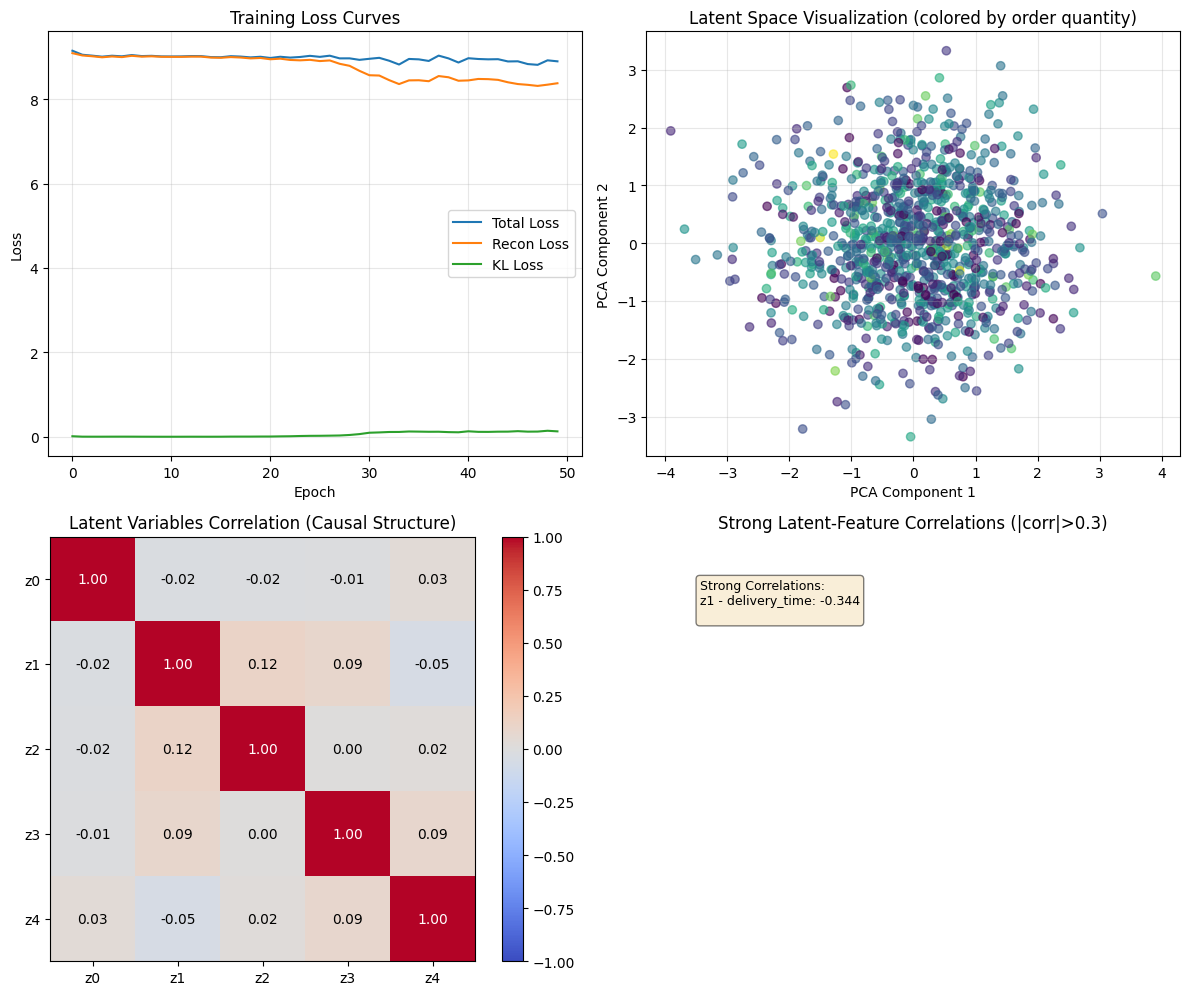


CausalVAE model training completed
Input dimension: 9
Latent variable dimension: 5
Beta parameter: 4.0
Training epochs: 50

Latent variable statistics:
  z0: mean=0.0084, std=1.0106
  z1: mean=0.0285, std=0.9841
  z2: mean=-0.0434, std=0.9877
  z3: mean=-0.0025, std=1.0364
  z4: mean=0.0635, std=0.9931

Strong correlations found:
  z1 with delivery_time: correlation coefficient = -0.344


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import networkx as nx

def build_causal_vae(data_path='fastship_dataset.csv', z_dim=5, beta=4.0, epochs=50, batch_size=32):
    """
    Build a simplified CausalVAE model combining β-VAE and NOTEARS concepts.

    Input parameters:
    - data_path: Path to the dataset
    - z_dim: Latent variable dimension
    - beta: Beta parameter in β-VAE
    - epochs: Number of training epochs
    - batch_size: Batch size

    Output:
    - Training loss curves
    - Latent variable visualization
    - Latent variable correlation plot (simulating causal structure)

    Main functionality:
    Implements a simplified CausalVAE, combining the generative capability of VAE with constraints for causal structure.
    """
    # 1. Load and preprocess data
    df = pd.read_csv(data_path)

    # Select observable features (exclude date and latent factors)
    observed_features = ['order_quantity', 'delivery_distance', 'weather_impact',
                         'is_holiday', 'is_promotion', 'delivery_time',
                         'satisfaction', 'day_of_week', 'geo_cluster_encoded']

    X = df[observed_features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X_scaled)
    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 2. Define the CausalVAE model
    class CausalVAE(nn.Module):
        def __init__(self, input_dim, z_dim, beta=4.0):
            super().__init__()
            self.beta = beta
            self.z_dim = z_dim

            # Encoder
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
            )
            self.fc_mu = nn.Linear(32, z_dim)
            self.fc_logvar = nn.Linear(32, z_dim)

            # Decoder
            self.decoder = nn.Sequential(
                nn.Linear(z_dim, 32),
                nn.ReLU(),
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Linear(64, input_dim)
            )

        def encode(self, x):
            h = self.encoder(x)
            mu = self.fc_mu(h)
            logvar = self.fc_logvar(h)
            return mu, logvar

        def reparameterize(self, mu, logvar):
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std

        def decode(self, z):
            return self.decoder(z)

        def forward(self, x):
            mu, logvar = self.encode(x)
            z = self.reparameterize(mu, logvar)
            x_recon = self.decode(z)
            return x_recon, mu, logvar, z

    # 3. Training function
    def train_model(model, dataloader, epochs, lr=1e-3):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        losses = []

        for epoch in range(epochs):
            total_loss = 0
            recon_loss_total = 0
            kl_loss_total = 0

            for batch in dataloader:
                x = batch[0]
                optimizer.zero_grad()

                x_recon, mu, logvar, z = model(x)

                # Reconstruction loss
                recon_loss = F.mse_loss(x_recon, x, reduction='sum')

                # KL divergence loss
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

                # Total loss = reconstruction loss + β * KL divergence
                loss = recon_loss + model.beta * kl_loss

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                recon_loss_total += recon_loss.item()
                kl_loss_total += kl_loss.item()

            avg_loss = total_loss / len(X)
            avg_recon = recon_loss_total / len(X)
            avg_kl = kl_loss_total / len(X)

            losses.append((avg_loss, avg_recon, avg_kl))

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, '
                      f'Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}')

        return losses

    # 4. Initialize and train the model
    input_dim = X_scaled.shape[1]
    model = CausalVAE(input_dim, z_dim, beta)
    losses = train_model(model, dataloader, epochs)

    # 5. Extract latent variables
    with torch.no_grad():
        mu, logvar = model.encode(X_tensor)
        z_samples = model.reparameterize(mu, logvar).numpy()

    # 6. Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Loss curves
    axes[0, 0].plot([l[0] for l in losses], label='Total Loss')
    axes[0, 0].plot([l[1] for l in losses], label='Recon Loss')
    axes[0, 0].plot([l[2] for l in losses], label='KL Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Latent variable PCA visualization
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_samples)

    axes[0, 1].scatter(z_pca[:, 0], z_pca[:, 1], alpha=0.6, c=df['order_quantity'])
    axes[0, 1].set_xlabel('PCA Component 1')
    axes[0, 1].set_ylabel('PCA Component 2')
    axes[0, 1].set_title('Latent Space Visualization (colored by order quantity)')
    axes[0, 1].grid(True, alpha=0.3)

    # Latent variable correlation heatmap (simulating causal structure)
    z_df = pd.DataFrame(z_samples, columns=[f'z{i}' for i in range(z_dim)])
    corr_matrix = z_df.corr().values

    im = axes[1, 0].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1, 0].set_title('Latent Variables Correlation (Causal Structure)')
    axes[1, 0].set_xticks(range(z_dim))
    axes[1, 0].set_yticks(range(z_dim))
    axes[1, 0].set_xticklabels([f'z{i}' for i in range(z_dim)])
    axes[1, 0].set_yticklabels([f'z{i}' for i in range(z_dim)])
    plt.colorbar(im, ax=axes[1, 0])

    # Add text annotations
    for i in range(z_dim):
        for j in range(z_dim):
            axes[1, 0].text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha='center', va='center', color='black' if abs(corr_matrix[i, j]) < 0.7 else 'white')

    # Latent variable correlations with original features
    feature_corrs = []
    for i in range(z_dim):
        for j, feat in enumerate(observed_features):
            corr = np.corrcoef(z_samples[:, i], X[:, j])[0, 1]
            if abs(corr) > 0.3:  # Only show strong correlations
                feature_corrs.append((f'z{i}', feat, corr))

    axes[1, 1].axis('off')
    axes[1, 1].set_title('Strong Latent-Feature Correlations (|corr|>0.3)')

    # Display correlation text
    text_str = "Strong Correlations:\n"
    for z_name, feat, corr in sorted(feature_corrs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        text_str += f"{z_name} - {feat}: {corr:.3f}\n"

    axes[1, 1].text(0.1, 0.9, text_str, transform=axes[1, 1].transAxes,
                   verticalalignment='top', fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('causal_vae_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 7. Output model information
    print("\n" + "="*50)
    print("CausalVAE model training completed")
    print("="*50)
    print(f"Input dimension: {input_dim}")
    print(f"Latent variable dimension: {z_dim}")
    print(f"Beta parameter: {beta}")
    print(f"Training epochs: {epochs}")
    print(f"\nLatent variable statistics:")
    for i in range(z_dim):
        print(f"  z{i}: mean={z_samples[:, i].mean():.4f}, std={z_samples[:, i].std():.4f}")

    print(f"\nStrong correlations found:")
    for z_name, feat, corr in sorted(feature_corrs, key=lambda x: abs(x[2]), reverse=True)[:5]:
        print(f"  {z_name} with {feat}: correlation coefficient = {corr:.3f}")

    # Return the trained model and latent variables
    return model, z_samples

# Run the CausalVAE
if __name__ == "__main__":
    print("Starting CausalVAE model training...")
    model, z_samples = build_causal_vae(
        data_path='fastship_dataset.csv',
        z_dim=5,
        beta=4.0,
        epochs=50,  # Use fewer epochs for a quick demonstration
        batch_size=32
    )